# Preliminary analysis

## Are artific people also scientistic ? (find a catch phrase like "Make it pope-litical")

We are often put into boxes regarding our interests and hobbies, we have friends that have the same interests as us, we chose a department when we are young at high school and social media makes a lot of suggestions based on our past interests. We sometimes hear that artistic and scientific people are different, closed-minded in their subject and not interested in the other one. The main goal of this project is to study this stereotype by using the YouNiverse dataset using comments and video metadata files. We want to determine whether comment authors that have at least a particular amount of comments solely comment on one or both of the following categories: artistic/scientific, or both. We can examine whether it's true or not that the majority of profiles that comment on art videos never comment on scientific videos. To draw some conclusions about people’s interests, we can determine if the profiles that consider both types of videos mix them together over one time period or if they are more evenly distributed over several.

## Useful libraries

In [2]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import matplotlib as mpl
import seaborn as sns
sns.color_palette("colorblind")
sns.set_theme()
import pandas as pd
import numpy as np
from scipy import stats
mpl.rcParams['figure.facecolor'] = 'white'
import os
import sys
import re
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'matplotlib_venn'

## Data preprocessing

### Data sampling

Since we are studying youtube users, we choose to start the data sampling from them.

What we do is recover a fixed number of users, let's say around 1 million on carry on our analysis on the video they commented on. We assume that with enough users, we will have a large enough sample of videos to be representative of all the videos.

Furthermore, we can take the first chunk of the comment file since the user are ordered in a random way.

In [ ]:
raw_comments_filename = 'raw_data/youtube_comments.tsv.gz'
raw_video_metadata_filename = 'raw_data/yt_metadata_en.jsonl.gz'

In [ ]:
chunksize = 12e6 + 1    # add one so we have a nice round number because we remove the last user 

# get one chunk of comments to recover num_users
for df_comments in pd.read_csv(raw_comments_filename, sep='\t', chunksize=chunksize, compression='infer'):
    
    # Since the last author could be cutoff, we remove the last author
    df_comments = df_comments[df_comments.author != df_comments.iloc[-1]['author']]

    print('Number of users: %d' % len(df_comments.author.unique()))        # should bebetween 500 000 and 1 million

    df_comments.to_feather('comments.feather')

    break

Number of users: 619701


In [ ]:
df_comments.head()

,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0


In [ ]:
# Get unique video ids
video_ids = pd.DataFrame({'video_id': df_comments['video_id'].unique()})
print('Number of videos: %d' % len(video_ids))

Number of videos: 4136765


In [ ]:
# clear memory before handling more data
print('Cleared %d bytes of memory' % sys.getsizeof(df_comments))
%xdel df_comments

Cleared 1199999816 bytes of memory


After gathering our user and identifying what videos they commented on, we recover metadata on these video for our analysis by computing the intersection chunkwize of the total video set and the videos our sample of user have commented on.

In [ ]:
# They are around 73M videos in this file
chunksize = 500e3
max_num_chunk = 74e6 // chunksize

# Define dtypes to have to most memory optimization possible
# After some tests, using dtypes seems to be a little bit beneficial
# One chunk:  
#   - without dtypes:
#       time: 32.7s
#       space: 62574070 B
#   - with dtypes
#       time: 29.8s
#       space: 56003766 B

dtype = {
    'title': str,
    'display_id': str,
    'description': str,
    'categories': 'category',
    'crawl_date': str,
    'upload_date': str,
    'dislike_count': int,
    'like_count': int,
    'duration': int,
    'view_count': int,
    'tags': object,
}

dfs = []
chunk_num = 1
for chunk in pd.read_json(raw_video_metadata_filename, dtype=dtype, chunksize=chunksize, lines=True):

    # remove unused fields for space optimizations: title, description, crawldate
    chunk.drop(['title', 'description', 'crawl_date'], axis=1 , inplace=True)

    # keep only videos where one of our user in our user pool commented
    # then remove redudant column display_id
    chunk = pd.merge(chunk, video_ids, left_on='display_id', right_on='video_id').drop('display_id', axis=1)

    print('Chunk %d out of %d. Kept %d out of %d videos.' % (chunk_num, max_num_chunk, len(chunk), chunksize))

    dfs.append(chunk)

    chunk_num += 1
    

videos_metadata = pd.concat(dfs).reset_index(drop=True)

# Save videoset
videos_metadata.to_feather('video_metadata.feather')

Chunk 1 out of 148. Kept 34962 out of 500000 videos.
Chunk 2 out of 148. Kept 26111 out of 500000 videos.
Chunk 3 out of 148. Kept 33473 out of 500000 videos.
Chunk 4 out of 148. Kept 28317 out of 500000 videos.
Chunk 5 out of 148. Kept 21542 out of 500000 videos.
Chunk 6 out of 148. Kept 43322 out of 500000 videos.
Chunk 7 out of 148. Kept 29785 out of 500000 videos.
Chunk 8 out of 148. Kept 37594 out of 500000 videos.
Chunk 9 out of 148. Kept 24331 out of 500000 videos.
Chunk 10 out of 148. Kept 30089 out of 500000 videos.
Chunk 11 out of 148. Kept 25326 out of 500000 videos.
Chunk 12 out of 148. Kept 23741 out of 500000 videos.
Chunk 13 out of 148. Kept 21987 out of 500000 videos.
Chunk 14 out of 148. Kept 27249 out of 500000 videos.
Chunk 15 out of 148. Kept 30069 out of 500000 videos.
Chunk 16 out of 148. Kept 26012 out of 500000 videos.
Chunk 17 out of 148. Kept 30458 out of 500000 videos.
Chunk 18 out of 148. Kept 25333 out of 500000 videos.
Chunk 19 out of 148. Kept 31086 out o

### Data importation

In [3]:
df_videos = pd.read_feather("video_metadata.feather")

NameError: name 'pd' is not defined

In [8]:
print(len(df_videos))
df_videos.head()

4136765


,categories,channel_id,dislike_count,duration,like_count,tags,upload_date,view_count,video_id
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,11423.0,1762,29891.0,"lego city police for kids,lego polizi,lego mov...",2017-12-08 00:00:00,23152662.0,mp9gt45aHxY
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,1561.0,1146,6118.0,"lego dinosaurs,lego jurassic world,lego dinosa...",2017-12-07 00:00:00,4028426.0,hn2zYwqSINY
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,206.0,1706,2235.0,"lego marvel super heroes 2,lego super heroes 2...",2017-11-18 00:00:00,585746.0,UTZLSHaE4Sw
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,799.0,2146,2501.0,"lego dinosaurs,lego jurassic world,lego t-rex,...",2017-02-21 00:00:00,1547805.0,SWZG-ba1qDk
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2548.0,2196,8780.0,"lego batman movie,the batman movie,new batman ...",2017-02-13 00:00:00,6674760.0,3vQK78eUg2A


### Data filtering

Explain: artistic video category do not exist => so we made ours
=> explain how with dictionnaries

In [9]:
# Formatting the tags column in order to do exact word matching

##  USE str.strip !!! 
# Can't use str.strip, only works for leading and trailing characters

df_videos = df_videos[:30000] # for easiness of processing
df_videos['tags'] = df_videos['tags'].apply(str.lower)
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=(';',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=(',',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=('(',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=(')',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=('&',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=('|',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.split)

In [10]:
df_videos = df_videos.loc[df_videos.categories != "Gaming"] 
df_videos.head()

,categories,channel_id,dislike_count,duration,like_count,tags,upload_date,view_count,video_id
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2548.0,2196,8780.0,"[lego, batman, movie, the, batman, movie, new,...",2017-02-13 00:00:00,6674760.0,3vQK78eUg2A
5,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,613.0,398,49464.0,"[vine, vines, vine, compilation, chaotic, good]",2019-02-05 00:00:00,1142835.0,BDnF-EgqAGw
6,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,588.0,375,32726.0,"[vines, vine, vine, compilation, neutral, good...",2019-01-31 00:00:00,819654.0,wrTIXbQED80
7,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,673.0,319,30596.0,[],2019-01-15 00:00:00,736707.0,yd7d51AgSso
8,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,991.0,367,75504.0,"[vine, vine, compilation, vines, lawful, good]",2019-01-09 00:00:00,1636316.0,-Ia18bqO-9w


Some helper functions

In [11]:
def return_word_in_list(tags, word_list):
    
    # Make sets from the list of words
    x = set(tags)
    y = set(word_list)
    
    # Use intersection function of set type to quickly find which word are in both lists/sets
    z = x.intersection(y)

    return z

In [12]:
def check_tags_in_list(tags, word_list):
    word_present = 0
    
    # Make sets from the list of words
    x = set(tags)
    y = set(word_list)
    
    # Use intersection function of set type to quickly find which word are in both lists/sets
    z = x.intersection(y)
    
    # If the intersection is larger than 0, then there is at least a common word between both sets 
    if len(z) > 0:
        word_present = 1
    return word_present

#### Artistic videos

In [13]:
# Art words
words_path_visual = "dictionaries/visual_arts.txt"
words_path_performing = "dictionaries/performing_art.txt"
words_path_literary = "dictionaries/literary_art.txt"

visual_arts = pd.read_csv(words_path_visual)
literary_arts = pd.read_csv(words_path_literary)
performing_arts = pd.read_csv(words_path_performing)

visual_words = visual_arts.values
literary_words = literary_arts.values
performing_words = performing_arts.values

visual_words = visual_words.flatten()
literary_words = literary_words.flatten()
performing_words = performing_words.flatten()


# maybe only print samples of each
 
print(visual_words)
print(literary_words)
print(performing_words)

['ceramics' 'draw' 'draw in' 'drawing' 'drawings' 'paint' 'painter'
 'painting' 'paintings' 'sculpt' 'sculptor' 'sculpture' 'sculptures'
 'statue' 'statues' 'statuary' 'fresco' 'printmaking' 'linoleum'
 'linocut ' 'design' 'designs' 'designer' 'designers' 'craft' 'crafts'
 'photography' 'film-making' 'architect' 'architecture' 'architectures'
 'maquette' 'maquettes' 'pottery' 'potteries' 'earthenware' 'earthenwares'
 'terracotta' 'vase' 'vases' 'clayware' 'mosaic' 'mosaics' 'carve'
 'carving' 'motifs' 'sketching' 'sketchings' 'sketched' 'doodle' 'doodles'
 'doodling' 'dooodlings' 'acrylic' 'acrylic paint' 'oil paint'
 'spray paint' 'artwork' 'artworks' 'photojournalism' 'aperture'
 'exposure' 'museum' 'museums']
['literatures' 'writing' 'text' 'texts' 'poetry' 'prose' 'assonance'
 'alliteration' 'rhythm' 'poem' 'poems' 'novel' 'novels' 'romance'
 'novella' 'theatre' 'article' 'articles' 'biography' 'biographies'
 'essay' 'essays' 'pamphlet' 'abstract' 'book' 'books' 'letter' 'letters'


In [14]:
df_videos['visual_art'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, visual_words))
df_videos['literary_art'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, literary_words))
df_videos['performing_art'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, performing_words))
df_videos["art"] = 0
df_videos["art"].loc[(df_videos.visual_art == 1) | (df_videos.literary_art == 1) | (df_videos.performing_art == 1)] = 1

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_28984\1513569392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_videos["art"].loc[(df_videos.visual_art == 1) | (df_videos.literary_art == 1) | (df_videos.performing_art == 1)] = 1


In [15]:
df_videos.head()

,categories,channel_id,dislike_count,duration,like_count,tags,upload_date,view_count,video_id,visual_art,literary_art,performing_art,art
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2548.0,2196,8780.0,"[lego, batman, movie, the, batman, movie, new,...",2017-02-13 00:00:00,6674760.0,3vQK78eUg2A,0,0,0,0
5,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,613.0,398,49464.0,"[vine, vines, vine, compilation, chaotic, good]",2019-02-05 00:00:00,1142835.0,BDnF-EgqAGw,0,0,0,0
6,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,588.0,375,32726.0,"[vines, vine, vine, compilation, neutral, good...",2019-01-31 00:00:00,819654.0,wrTIXbQED80,0,0,0,0
7,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,673.0,319,30596.0,[],2019-01-15 00:00:00,736707.0,yd7d51AgSso,0,0,0,0
8,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,991.0,367,75504.0,"[vine, vine, compilation, vines, lawful, good]",2019-01-09 00:00:00,1636316.0,-Ia18bqO-9w,0,0,0,0


In [16]:
df_videos['visual_art_word'] = df_videos['tags'].apply(lambda x : return_word_in_list(x, visual_words))
df_videos['literary_art_word'] = df_videos['tags'].apply(lambda x : return_word_in_list(x, literary_words))
df_videos['performing_art_word'] = df_videos['tags'].apply(lambda x : return_word_in_list(x, performing_words))

In [17]:
df_art = df_videos.loc[df_videos.art == 1]

#### Scientific videos

Explain how we categorize and filter scientific videos between theoretical and practical science.

Not based on categories but only on dictionary filtering.

Define dictionaries for theoretical and practical science videos.

In [18]:
# Science words
words_path_natural = "dictionaries/natural_science.txt"
words_path_technical = "dictionaries/technical_science.txt"

natural_science = pd.read_csv(words_path_natural)
technical_science = pd.read_csv(words_path_technical)

natural_words = natural_science.values
technical_words = technical_science.values

natural_words = natural_words.flatten()
technical_words = technical_words.flatten()

# maybe only print samples of each
 
print(natural_words)
print(technical_words)

['quantum' 'physics' 'mathematics' 'atom' 'relativity' 'gravity'
 'scientific' 'scientifics' 'theorem' 'theorems' 'spactime' 'einstein'
 'entropy' 'entropies' 'molecule' 'molecules' 'atomism' 'magnetism'
 'galaxy' 'electron' 'metaphysics' 'universe' 'metaphysical'
 'theoretician' 'theoreticians' 'physicist' 'physicists' 'astronomy'
 'axiom' 'axioms' 'archimede' 'archimedes' 'pythagoras' 'mole'
 'oscillation' 'lorentz' 'maxwell' 'photoelectric' 'newton' 'maths'
 'radioactivity' 'arithmetic' 'geometry' 'mathematical' 'chemistry'
 'particle' 'particles' 'riemann' 'chemistries' 'biology' 'cellule' 'cell'
 'cells' 'biophysics' 'thermodynamics' 'optics' 'landau' 'meteorology'
 'geology' 'astrochemistry' 'kepler' 'spectroscope' 'geophysics'
 'bioscience' 'medicine' 'medical' 'research' 'species' 'galileo'
 'scientist' 'alchemy' 'measure' 'measures' 'accuracy' 'logic' 'genetics'
 'anatomy' 'anatomies' 'climatology' 'atoms' 'ion' 'comet' 'algebra'
 'analysis' 'statistics' 'calculus' 'function']

In [19]:
df_videos['natural_science'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, natural_words))
df_videos['technical_science'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, technical_words))
df_videos["science"] = 0
df_videos["science"].loc[(df_videos.natural_science == 1) | (df_videos.technical_science == 1)] = 1

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_28984\1231292729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_videos["science"].loc[(df_videos.natural_science == 1) | (df_videos.technical_science == 1)] = 1


In [20]:
df_videos['natural_science_word'] = df_videos['tags'].apply(lambda x : return_word_in_list(x, natural_words))
df_videos['technical_science_word'] = df_videos['tags'].apply(lambda x : return_word_in_list(x, technical_words))

In [21]:
df_science = df_videos.loc[df_videos.science == 1]

#### User profiles

Add columns for commented_artistic and commented_scientific (boolean values)

## Exploratory Data Analysis

### Videos

To have a global overview:

Plot of video distribution by categories (from youtube)

Then plot artistic video % vs scientific video % (pie chart).

Then add venn diagram of the intersections between artistic and scientific video

Then add time plot of percentage of views on artistic vs scientific videos

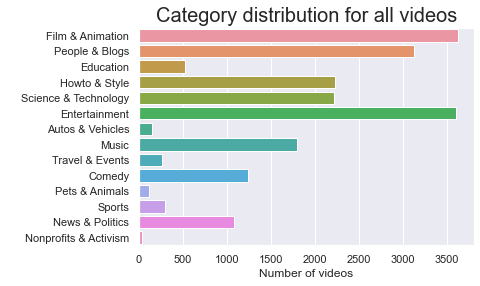

In [22]:
fig = sns.countplot(y = df_videos.categories)
fig.axes.set_title("Category distribution for all videos",fontsize=20)
fig.set_xlabel("Number of videos")
fig.set_ylabel(" ")

plt.show()

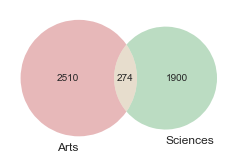

In [23]:
# Making sets out of indexes of Arts and Sciences videos
set_arts = set(df_art.index)
set_science = set(df_science.index)


# Venn diagram of the Artistic videos
plt.figure(figsize=(4,4))
venn2([set_arts, set_science], ['Arts', 'Sciences'])
plt.show()

In [24]:
pie_sums_domains = df_videos[["art", "science"]].sum()
# sum_arts.plot(kind="pie", labels = ["Visual Art", "Literary Art", "Performing Art"], autopct='%1.1f%%')
# plt.title("Art category distribution")
# plt.ylabel("")
pie_sums_domains

art        2784
science    2174
dtype: int64

Since we have identified which videos fall under our vision of "Artistic videos", let's look at their distribution within the Categories Youtube has defined:

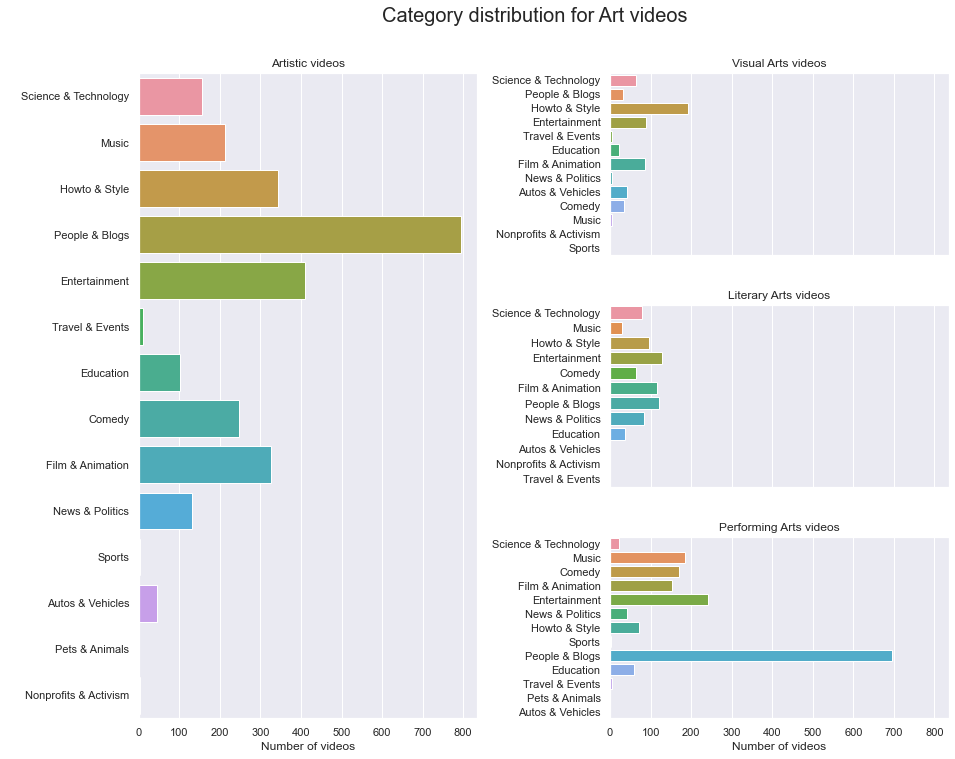

In [25]:
# Bar/count plots of the categories for Art videos
fig, axs = plt.subplot_mosaic([['Left', 'TopRight'],['Left', 'CenterRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1, 1]}, figsize=(12,10), sharex = True)
fig.suptitle('Category distribution for Art videos', fontsize=20, y=1.03)
fig.tight_layout(w_pad=10.0, h_pad = 4)

sns.countplot(y = df_art.categories, ax = axs['Left'])
axs['Left'].set_title('Artistic videos')
axs['Left'].set_ylabel(' ')
axs['Left'].set_xlabel('Number of videos')

sns.countplot(y = df_art[df_art.visual_art==1].categories, ax = axs['TopRight'])
axs['TopRight'].set_title('Visual Arts videos')
axs['TopRight'].set_ylabel(' ')
axs['TopRight'].set_xlabel(' ')

sns.countplot(y = df_art[df_art.literary_art==1].categories, ax = axs['CenterRight'])
axs['CenterRight'].set_title('Literary Arts videos')
axs['CenterRight'].set_ylabel(' ')
axs['CenterRight'].set_xlabel(' ')

sns.countplot(y = df_art[df_art.performing_art==1].categories, ax = axs['BottomRight'])
axs['BottomRight'].set_title('Performing Arts videos')
axs['BottomRight'].set_ylabel(' ')
axs['BottomRight'].set_xlabel('Number of videos')

plt.show()

Similarly, we can look at the distribution within the Youtube categories for our "Science videos":

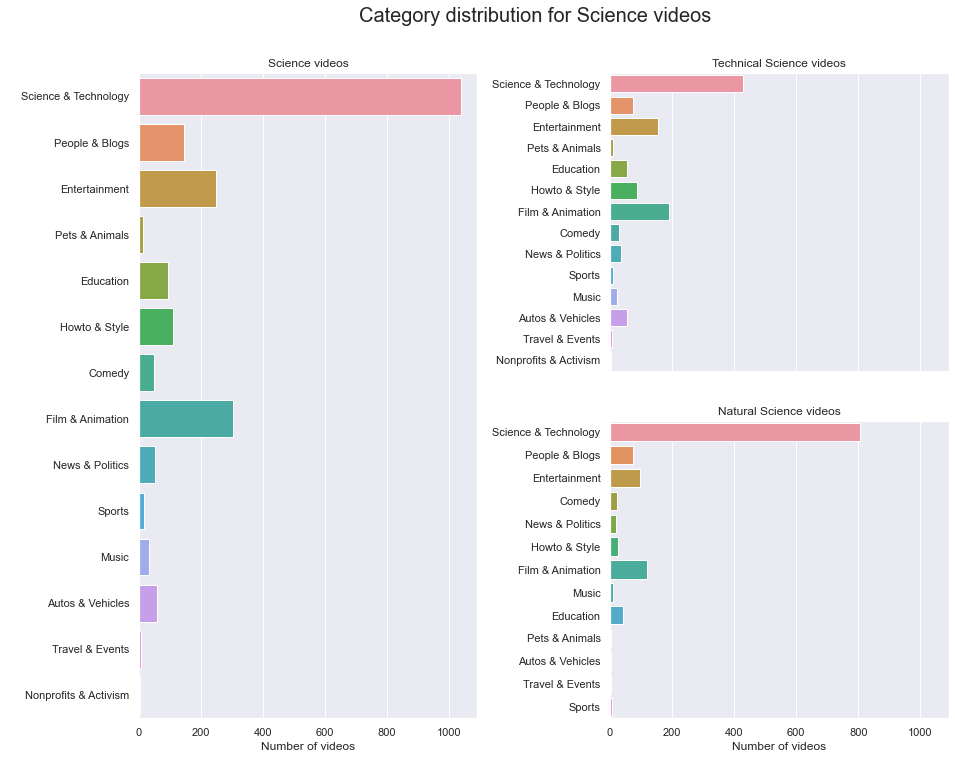

In [26]:
# Bar/count plots of the categories for Science videos
fig, axs = plt.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1, 1]}, figsize=(12,10), sharex = True)
fig.suptitle('Category distribution for Science videos', fontsize=20, y=1.03)
fig.tight_layout(w_pad=10.0, h_pad = 4)

sns.countplot(y = df_science.categories, ax = axs['Left'])
axs['Left'].set_title('Science videos')
axs['Left'].set_ylabel(' ')
axs['Left'].set_xlabel('Number of videos')

sns.countplot(y = df_science[df_science.technical_science==1].categories, ax = axs['TopRight'])
axs['TopRight'].set_title('Technical Science videos')
axs['TopRight'].set_ylabel(' ')
axs['TopRight'].set_xlabel(' ')

sns.countplot(y = df_science[df_science.natural_science==1].categories, ax = axs['BottomRight'])
axs['BottomRight'].set_title('Natural Science videos')
axs['BottomRight'].set_ylabel(' ')
axs['BottomRight'].set_xlabel('Number of videos')

plt.show()

### Artistic videos

#### Artistic domains distribution and time dependancy

Add time plot on the left of the pie chart

In [27]:
perc = (df_art.shape[0]*100)/df_videos.shape[0]
print("The art category corresponds to", round(perc, 2), "% of the videos.")

The art category corresponds to 13.72 % of the videos.


Text(0, 0.5, '')

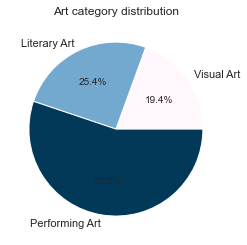

In [28]:
sum_arts = df_art[["visual_art", "literary_art", "performing_art"]].sum()
sum_arts.plot(kind="pie", labels = ["Visual Art", "Literary Art", "Performing Art"], autopct='%1.1f%%', colormap = 'PuBu')
plt.title("Art category distribution")
plt.ylabel("")

In [ ]:
# df_art.reset_index(inplace=True, drop=True)

In [ ]:
df_art['month_year'] = [datetime(year, month, 1) for year, month in zip(df_art.upload_date.dt.year, df_art.upload_date.dt.month)]
month_years = df_art['month_year'].unique()

percentages_visual = []
percentages_performing = []
percentages_literary = []

for month_year in month_years:
    total_art_videos = ((df_art['month_year'] == month_year) & (df_art['visual_art'] == 1)).sum() \
    + ((df_art['month_year'] == month_year) & (df_art['performing_art'] == 1)).sum() \
    + ((df_art['month_year'] == month_year) & (df_art['literary_art'] == 1)).sum()

    percentages_visual.append(((df_art['month_year'] == month_year) & (df_art['visual_art'] == 1)).sum()/total_art_videos)
    percentages_performing.append(((df_art['month_year'] == month_year) & (df_art['performing_art'] == 1)).sum()/total_art_videos)
    percentages_literary.append(((df_art['month_year'] == month_year) & (df_art['literary_art'] == 1)).sum()/total_art_videos)


C:\Users\gasto\AppData\Local\Temp\ipykernel_1100\3959402358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_art['month_year'] = [datetime(year, month, 1) for year, month in zip(df_art.upload_date.dt.year, df_art.upload_date.dt.month)]


In [ ]:
df_art_time = pd.DataFrame({
    'month_year': month_years,
    'percentage_visual': percentages_visual,
    'percentage_performing': percentages_performing,
    'percentage_literary': percentages_literary,
})

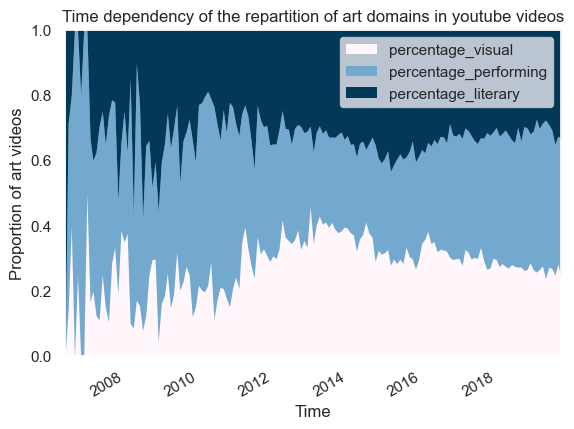

In [ ]:
df_art_time.plot.area('month_year', ['percentage_visual', 'percentage_performing', 'percentage_literary'], colormap='PuBu', lw=0)
plt.title('Time dependency of the repartition of art domains in youtube videos')
plt.ylim([0, 1])
plt.ylabel('Proportion of art videos')
plt.xlabel('Time')
plt.margins(0)
plt.show()

So two rows:

row 1: percentage of videos per domain => pie + time
row 2: percentage of views per domain => pie + time


Check if there is a consistency of uploading artistic videos or if there are some patterns.

=> update with new dataset

=> instead of video count, plot the percentage of artistic video views vs percentage

In [29]:
# Convert upload date to only date format
# df_videos['upload_date'] = pd.to_datetime(df_videos['upload_date'], format='%Y-%m-%d').dt.date
df_art['upload_date'] = pd.to_datetime(df_art['upload_date'], format='%Y-%m-%d').dt.date

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_28984\3749651317.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_art['upload_date'] = pd.to_datetime(df_art['upload_date'], format='%Y-%m-%d').dt.date


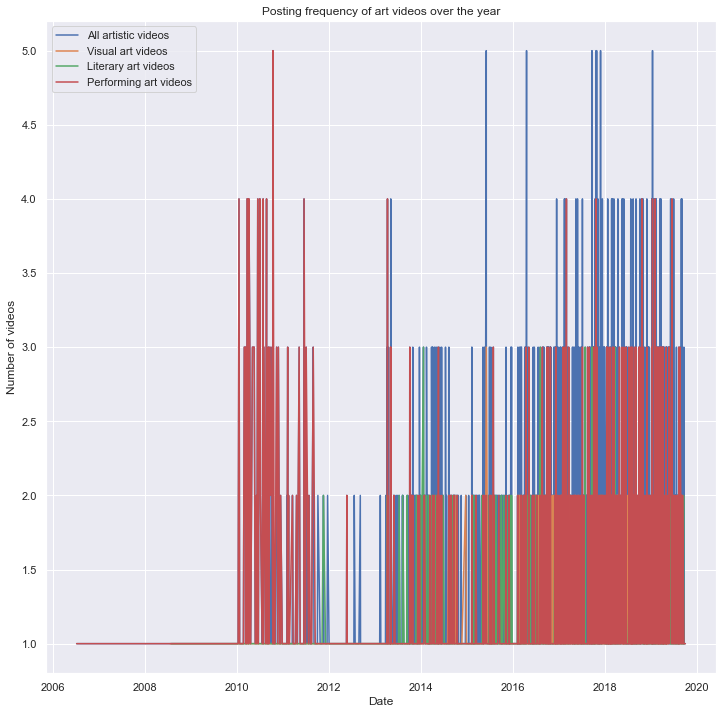

In [30]:
all_art_vid_count_year = df_art.groupby("upload_date").count().channel_id
vis_art_vid_count_year = df_art[df_art.visual_art==1].groupby("upload_date").count().channel_id
lit_art_vid_count_year = df_art[df_art.literary_art==1].groupby("upload_date").count().channel_id
perf_art_vid_count_year = df_art[df_art.performing_art==1].groupby("upload_date").count().channel_id

plt.figure(figsize=(12,12))
plt.plot(all_art_vid_count_year, label="All artistic videos")
plt.plot(vis_art_vid_count_year, label="Visual art videos")
plt.plot(lit_art_vid_count_year, label="Literary art videos")
plt.plot(perf_art_vid_count_year, label="Performing art videos")
plt.legend()
plt.title('Posting frequency of art videos over the year')
plt.xlabel('Date')
plt.ylabel('Number of videos')
plt.show()


In [31]:
# Test for only percentages

# all_art_vid_count_year = df_art.groupby("upload_date").count().channel_id
# vis_art_vid_count_year = df_art[df_art.visual_art==1].groupby("upload_date").count().channel_id
# lit_art_vid_count_year = df_art[df_art.literary_art==1].groupby("upload_date").count().channel_id
# perf_art_vid_count_year = df_art[df_art.performing_art==1].groupby("upload_date").count().channel_id

# plt.figure(figsize=(15,15))
# plt.plot(vis_art_vid_count_year/all_art_vid_count_year, label="Visual art videos")
# plt.plot(lit_art_vid_count_year/all_art_vid_count_year, label="Literary art videos")
# plt.plot(perf_art_vid_count_year/all_art_vid_count_year, label="Performing art videos")
# plt.legend()
# plt.title('Posting frequency of art videos over the year')
# plt.xlabel('Date')
# plt.ylabel('Number of videos')
# plt.show()


#### Intersection of artistic domains

Using Venn diagram, we can see the distribution of types of art in defined artistic category, as well as see videos with two or all three tags

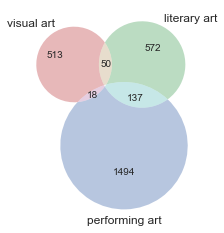

In [32]:
# Getting the videos corresponding to each Art domain
vis = df_art[(df_art['visual_art'] == 1)] 
lit = df_art[(df_art['literary_art'] == 1)]
perf = df_art[(df_art['performing_art'] == 1)]

set1 = set(vis.index)
set2 = set(lit.index)
set3 = set(perf.index)

# Venn diagram of the Artistic videos
plt.figure(figsize=(4,4))
venn3([set1, set2, set3], ['visual art', 'literary art', 'performing art'])
plt.show()

#### Artistic tags usage

Add subplot with word cloud next to one another with appropriate titles.

Remove histograms.

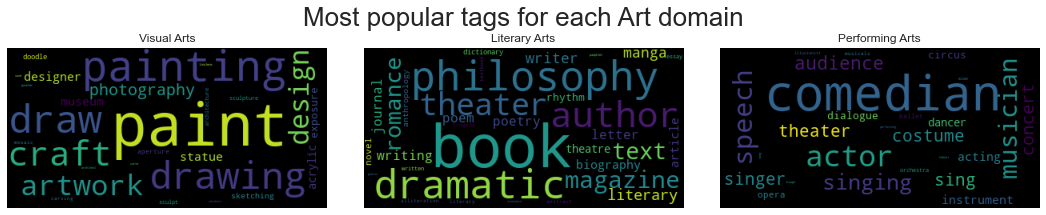

In [33]:
# Preparing lists for Wordclouds
list_vis = []
list_sth=[list_vis.extend(x) for x in df_art.loc[df_art.visual_art == 1].visual_art_word]
visual_string=(" ").join(list_vis)

list_lit = []
list_sth=[list_lit.extend(x) for x in df_art.loc[df_art.literary_art == 1].literary_art_word]
literary_string=(" ").join(list_lit)

list_perf = []
list_sth=[list_perf.extend(x) for x in df_art.loc[df_art.performing_art == 1].performing_art_word]
performing_string=(" ").join(list_perf)

# Wordclouds
wordcloud_vis = WordCloud(collocations=False).generate(visual_string)
wordcloud_lit = WordCloud(collocations=False).generate(literary_string)
wordcloud_perf = WordCloud(collocations=False).generate(performing_string)

# Plots
fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle('Most popular tags for each Art domain', fontsize=26)

axs[0].imshow(wordcloud_vis)
axs[0].axis("off")
axs[0].set_title('Visual Arts')

axs[1].imshow(wordcloud_lit)
axs[1].axis("off")
axs[1].set_title('Literary Arts')

axs[2].imshow(wordcloud_perf)
axs[2].axis("off")
axs[2].set_title('Performing Arts')

plt.tight_layout()

### Scientific videos

#### Scientific domains distribution and time dependancy

Add time plot on the left of the pie chart

In [34]:
perc = (df_science.shape[0]*100)/df_videos.shape[0]
print("The science category corresponds to", round(perc, 2), "% of the videos.")

The science category corresponds to 10.71 % of the videos.


Text(0, 0.5, '')

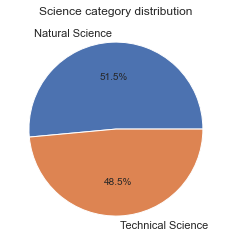

In [35]:
sum_science = df_science[["natural_science", "technical_science"]].sum()
sum_science.plot(kind="pie", labels = ["Natural Science", "Technical Science"], autopct='%1.1f%%')
plt.title("Science category distribution")
plt.ylabel("")

So two rows:

row 1: percentage of videos per domain => pie + time
row 2: percentage of views per domain => pie + time


Check if there is a consistency of uploading scientific videos or if there are some patterns.

=> update with new dataset

=> instead of video count, plot the percentage of scientific video views vs percentage

In [36]:
# Convert upload date to only date format
# df_videos['upload_date'] = pd.to_datetime(df_videos['upload_date'], format='%Y-%m-%d').dt.date
df_science['upload_date'] = pd.to_datetime(df_science['upload_date'], format='%Y-%m-%d').dt.date

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_28984\1960942849.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_science['upload_date'] = pd.to_datetime(df_science['upload_date'], format='%Y-%m-%d').dt.date


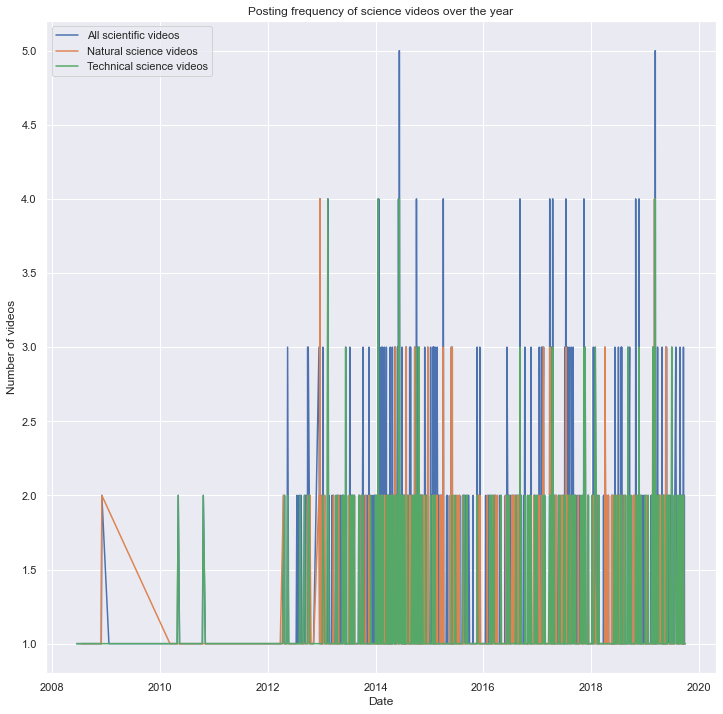

In [37]:
all_science_vid_count_year = df_science.groupby("upload_date").count().channel_id
nat_science_vid_count_year = df_science[df_science.natural_science==1].groupby("upload_date").count().channel_id
tec_science_vid_count_year = df_science[df_science.technical_science==1].groupby("upload_date").count().channel_id

plt.figure(figsize=(12,12))
plt.plot(all_science_vid_count_year, label="All scientific videos")
plt.plot(nat_science_vid_count_year, label="Natural science videos")
plt.plot(tec_science_vid_count_year, label="Technical science videos")
plt.legend()
plt.title('Posting frequency of science videos over the year')
plt.xlabel('Date')
plt.ylabel('Number of videos')
plt.show()


#### Intersection of scientific domains

Using Venn diagram, we can see the distribution of types of art in defined artistic category, as well as see videos with two or all three tags

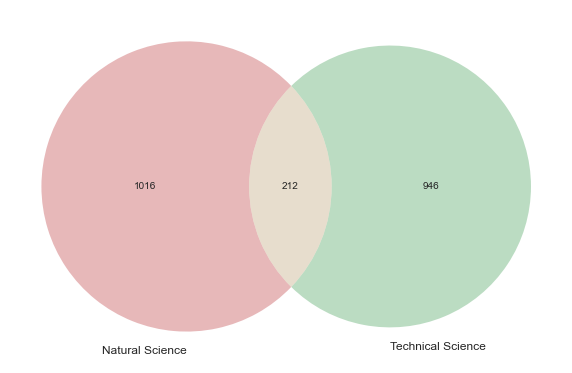

In [38]:
nat = df_science[(df_science['natural_science'] == 1)] 
tec = df_science[(df_science['technical_science'] == 1)]

plt.figure(figsize=(10,10))
set1 = set(nat.index)
set2 = set(tec.index)

venn2([set1, set2], ['Natural Science', 'Technical Science'])

plt.show()

#### Scientific tags usage

Add subplot with word cloud next to one another with appropriate titles.

Remove histograms.

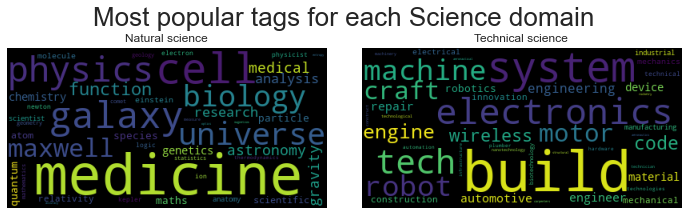

In [39]:
# Preparing lists for Wordclouds
list_nat = []
list_sth=[list_nat.extend(x) for x in df_science.loc[df_science.natural_science == 1].natural_science_word]
natural_string=(" ").join(list_nat)

list_tech = []
list_sth=[list_tech.extend(x) for x in df_science.loc[df_science.technical_science == 1].technical_science_word]
technical_string=(" ").join(list_tech)

# Wordclouds
wordcloud_nat = WordCloud(collocations=False).generate(natural_string)
wordcloud_tech = WordCloud(collocations=False).generate(technical_string)

# Plots
fig, axs = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Most popular tags for each Science domain', fontsize=26)

axs[0].imshow(wordcloud_nat)
axs[0].axis("off")
axs[0].set_title('Natural science')

axs[1].imshow(wordcloud_tech)
axs[1].axis("off")
axs[1].set_title('Technical science')

plt.tight_layout()

#### Scientific domains distribution and time dependency

#### Intersection of science domains

#### Scientific tags usage

### Users & comments

In [40]:
df_com = pd.read_feather("comments.feather")

In [41]:
print("We have", len(df_com), "different comments.")
df_com.head()

We have 11999998 different comments.


,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0


In [42]:
df_com_group = df_com.groupby("author").count()

In [43]:
com_mean = df_com_group["video_id"].mean()
geo_mean = stats.gmean(df_com_group["video_id"])
print("There are in average", round(com_mean, 2), "videos commented by user but the distribution have a lot of outliers so we can analyze the geometric mean instead which is :", round(geo_mean, 2))

There are in average 19.36 videos commented by user but the distribution have a lot of outliers so we can analyze the geometric mean instead which is : 3.65


In [44]:
N_outliers = 300
highest_com = df_com_group.loc[df_com_group.video_id > N_outliers]
normal_com = df_com_group.loc[df_com_group.video_id < N_outliers]
perc = highest_com.shape[0]*100/df_com_group.shape[0]
print(round(perc, 2), "% of the comenters commented on more than", N_outliers, "videos.")

0.98 % of the comenters commented on more than 300 videos.


We have a heavy-tailed distribution.


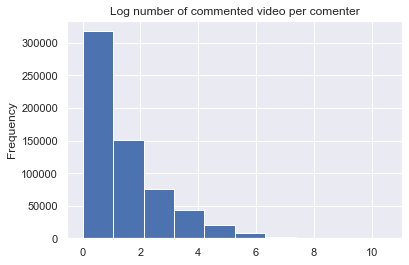

In [45]:
np.log(df_com_group.video_id).plot(kind = "hist")
plt.title("Log number of commented video per comenter")
print("We have a heavy-tailed distribution.")

#### Descriptive statistic 

mean/ variance/ median ...


### Others

In [36]:
# plt.figure(figsize=(15,15))
# sns.heatmap()
# plt.title("Posting of artistic videos over a year ")
# plt.xlabel('Months')
# plt.ylabel('Number of posted videos')
# plt.show()